In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import time
import scipy
import sklearn
import copy
import pickle
import os

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


## Read Hao dataset

In [3]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
labels = adata.obs['celltype.l1']
types = np.unique(labels).tolist()
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

## DEG LR classifier

In [6]:
def DEG_LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)
    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return clf, metrics, likelihood

In [13]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/DEG_L1/DEG_table')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)
likelihood_dict = {}

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = 10
    # print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics, celltype_likelihood = DEG_LR_classifier(adata, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics
    likelihood_dict[celltype] = celltype_likelihood

Constructing classifier for: B
(161764, 10)
likelihood > 0.5: 13669
Constructing classifier for: CD4_T
(161764, 10)
likelihood > 0.5: 44656
Constructing classifier for: CD8_T
(161764, 10)
likelihood > 0.5: 23894
Constructing classifier for: DC
(161764, 10)
likelihood > 0.5: 3024
Constructing classifier for: Mono
(161764, 10)
likelihood > 0.5: 49819
Constructing classifier for: NK
(161764, 10)
likelihood > 0.5: 18879
Constructing classifier for: other
(161764, 10)
likelihood > 0.5: 2411
Constructing classifier for: other_T
(161764, 10)
likelihood > 0.5: 3502


In [23]:
adata.obs['celltype.l1'].value_counts()

celltype.l1
Mono       49010
CD4_T      41001
CD8_T      25469
NK         18664
B          13800
other_T     6789
DC          3589
other       3442
Name: count, dtype: int64

In [19]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.index = adata.obs_names
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
L1_AAACCCAAGAAACTCA,0.000437,0.003643,0.000587,6.349809e-03,0.988107,0.000129,0.006616,0.001044
L1_AAACCCAAGACATACA,0.000455,0.807974,0.063331,1.799055e-09,0.000011,0.000390,0.003774,0.062539
L1_AAACCCACAACTGGTT,0.000037,0.720321,0.997957,6.623839e-10,0.000001,0.000120,0.002867,0.003483
L1_AAACCCACACGTACTA,0.000123,0.006488,0.002055,3.458766e-09,0.000006,0.967555,0.007985,0.145057
L1_AAACCCACAGCATACT,0.000031,0.515242,0.999077,5.646501e-11,0.000002,0.000914,0.005604,0.005522


## PreLect metrics - DEG10 metrics

In [14]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998393,0.995608,0.985507,0.990532,0.999576,0.999019,0.989669
CD4_T,0.870831,0.724813,0.790488,0.756227,0.934850,0.789379,0.669753
CD8_T,0.968875,0.926707,0.871221,0.898108,0.985114,0.951487,0.880344
DC,0.990511,0.831987,0.717270,0.770381,0.994342,0.867592,0.767761
Mono,0.992520,0.979246,0.996429,0.987763,0.997763,0.990463,0.982454
NK,0.978302,0.903595,0.908920,0.906250,0.995466,0.963831,0.893986
other,0.991593,0.933333,0.651163,0.767123,0.913174,0.779577,0.775831
other_T,0.968720,0.743662,0.388807,0.510638,0.927735,0.559578,0.524147


In [15]:
all_metrics_PreLect = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/LR_classifiers/LR_metrics_l1.csv', index_col=0)
PreLect_minus_DEG = all_metrics_PreLect - all_metrics_DEG
PreLect_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.000668,0.000826,0.007029,0.003945,0.000356,0.000447,0.004299
CD4_T,0.101901,0.222073,0.156319,0.190224,0.060478,0.197361,0.258764
CD8_T,0.002658,0.009147,0.008241,0.008636,0.003507,0.006938,0.010246
DC,0.007888,0.137851,0.240378,0.193313,0.005450,0.124617,0.195140
Mono,-0.000260,0.000107,-0.000979,-0.000431,0.000408,0.002737,-0.000622
NK,0.014261,0.065754,0.057325,0.061503,0.003215,0.030200,0.069592
other,0.000136,-0.006460,0.007963,-0.010812,0.017169,0.003249,-0.005419
other_T,0.016994,0.137345,0.373891,0.306745,0.058619,0.325503,0.288238


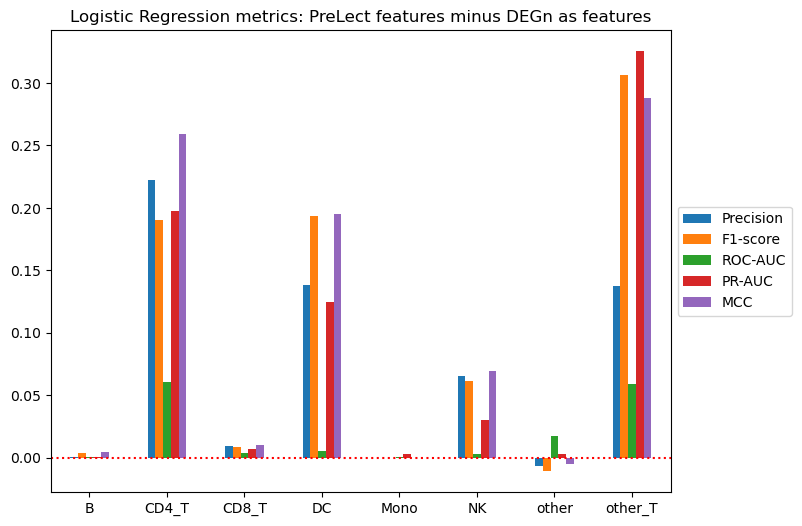

In [22]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = PreLect_minus_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression metrics: PreLect features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')


## Plot likelihood on UMAP

In [20]:
# Concatenate the likelihood_df with the adata.obs
adata.obs = pd.concat([adata.obs, likelihood_df], axis=1)
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,...,nFeature_RNA,leiden,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,...,2915,4,0.000437,0.003643,0.000587,6.349809e-03,0.988107,0.000129,0.006616,0.001044
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,...,1617,2,0.000455,0.807974,0.063331,1.799055e-09,0.000011,0.000390,0.003774,0.062539
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,...,1381,5,0.000037,0.720321,0.997957,6.623839e-10,0.000001,0.000120,0.002867,0.003483
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,...,1890,3,0.000123,0.006488,0.002055,3.458766e-09,0.000006,0.967555,0.007985,0.145057
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,...,1621,5,0.000031,0.515242,0.999077,5.646501e-11,0.000002,0.000914,0.005604,0.005522


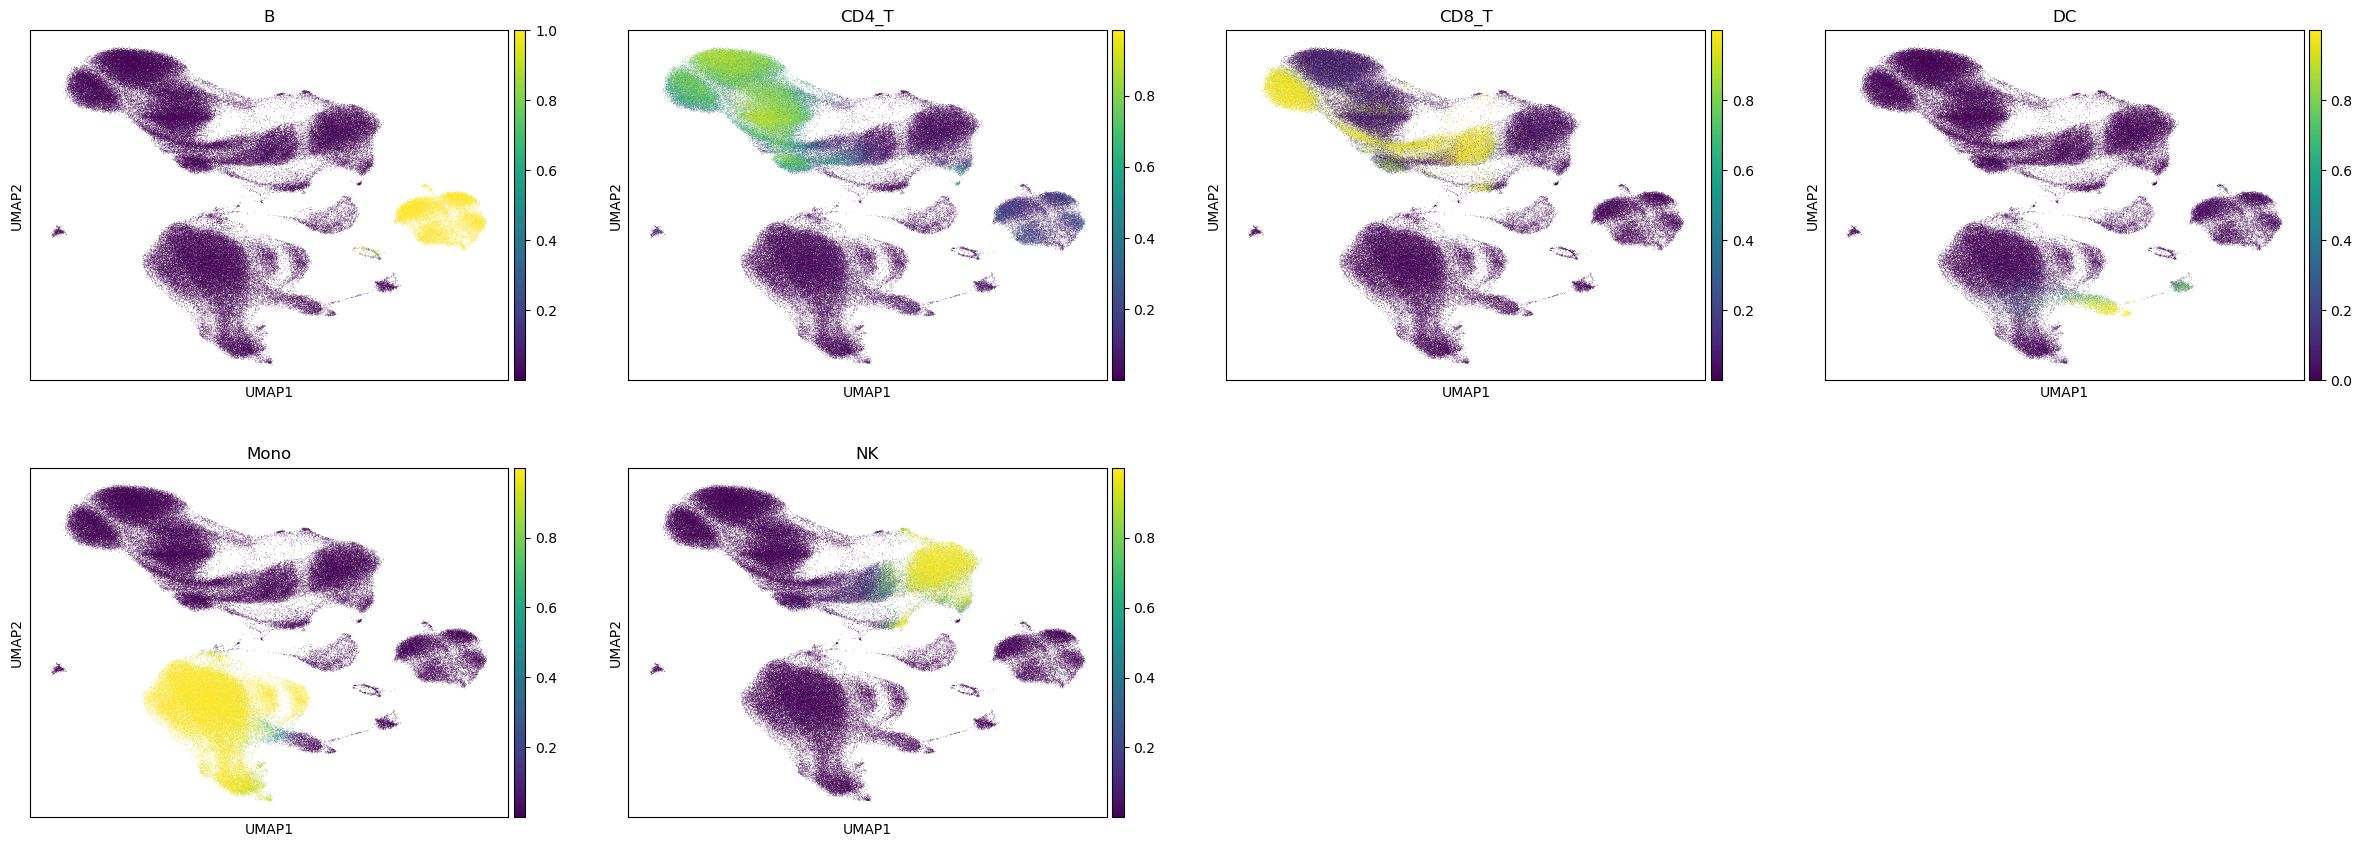

In [21]:
sc.pl.umap(adata, color=['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK'])